[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/matteo-bertini/Facial-Expression-Recognition)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matteo-bertini/Facial-Expression-Recognition/blob/main/Five_Layers_CNN.ipynb)

# Importing the libraries
The libraries to implement Five-Layers-CNN and related utilities are imported here.

In [1]:
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow import keras,convert_to_tensor
from tensorflow.keras.regularizers import L2
from sklearn.model_selection import train_test_split,StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D,ReLU,RandomRotation
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# GPU Check
This section checks whether the GPU is in use or not.

In [2]:
num_gpu_available = len(tf.config.list_physical_devices('GPU'))
if num_gpu_available == 0 :
  print("You are not using GPU.\n")
else:
  print("You are using GPU.\n")

You are using GPU.



In [3]:
# Command to run to see the specs of the assigned GPU. (only valid if GPU is in use)
!nvidia-smi

Fri Jan 13 15:41:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mounting Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset
The dataset provided by the file "icml_face.csv" file is uploaded and processed here.\
Specifically:


*   the csv file is transformed into a dataframe
*   the pixel column is manipulated so that it no longer contains 
    pixel strings but numpy arrays of size 48x48x1





In [5]:
# Loading icml_face_data.csv into dataframe df_icml
df_icml = pd.read_csv("/content/drive/MyDrive/Facial-Expression-Recognition/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv",sep=",")

# Columns renamed for easier access.
df_icml.rename(columns = {' Usage':'usage'}, inplace = True)
df_icml.rename(columns = {' pixels':'pixels'}, inplace = True)

# Transforming pixel strings into 48x48 tensors of float32
df_icml["pixels"] = df_icml['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48,1).astype('float32'))                                                          


# Training the Five-Layers-CNN in the classic way
In this section the Five-Layers-CNN will be trained in the "classical" way, that is by dividing the dataset into Train-Validation and Test sets.\
The Train set will be used to train the net, the Validation set to validate it at the end of each training epoch and the Test set to view its performance at the end of the training session.

## Builiding the Five-Layers-CNN from scratch
Here the architecture of Five-Layers-CNN is created from scratch.\
The structure of the network is the same as described in the paper, with some differences:


1.   The l2 regularizations have been removed
2.   A 2d convolution has been added



In [24]:
model = Sequential()
model._name = "Five-Layers-CNN"


# First Layer : Input

# Second Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (48, 48, 1),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.25))
#-------------------------------------------------------------------------------------------------------------------------------#

# Third Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.25))
#-------------------------------------------------------------------------------------------------------------------------------#

# Fourth Layer
#--------------------------------------------- ADDING THE 2D CONVOLUTION -------------------------------------------------------#
model.add(Conv2D(filters = 512,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Flatten(name='flatten'))     
model.add(Dense(512))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))
model.add(Dense(7,activation='softmax'))


# After creating the structure of the network, we visualize it in a compact way.
model.summary()

Model: "Five-Layers-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_17 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_17 (ReLU)             (None, 48, 48, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_18 (ReLU)             (None, 48, 48, 64)    

## Creating the Train-Val-Test split
Here the Train Set, Validation Set and Test Set are created.\
At the beginning the split was done according to the value of the "usage" column of the df_icml dataframe, but after noticing that using this strategy all the three sets were unbalanced, I opted to use the sklearn library. The functions made available by sklearn allow you to create sets in a proportional and balanced way.

In [7]:
# Creating the X numpyarray
X = df_icml["pixels"]
X = np.stack(X, axis=0)
print("X has shape: ")
print(X.shape)

# Creating the y numpyarray
y = df_icml["emotion"].to_numpy()
y = to_categorical(y)
print("y has shape: ")
print(y.shape)

print("\n")

# Data Augmentation phase 

# Declaration of the ImageDataGenerator with the transformations to apply to generate new images
data_gen = ImageDataGenerator(rotation_range = 15,width_shift_range = 0.15,height_shift_range = 0.15,shear_range = 0.15,zoom_range = 0.15,horizontal_flip = True)

# Disgust Class 

# Creating the X numpyarray with samples from disgust class
X_disg = df_icml.loc[df_icml['emotion'].isin([1])]["pixels"]
X_disg = np.stack(X_disg, axis=0)
print("X_disg has shape: ")
print(X_disg.shape)

# Creating the y numpyarray with samples from disgust class
y_disg = np.zeros((547,7))
for i in range (0,y_disg.shape[0]):
  y_disg[i][1] = 1 
print("y_disg has shape: ")
print(y_disg.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_disg)
  it = data_gen.flow(X_disg,y_disg,batch_size = 547,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1


# Surprise Class 

# Creating the X numpyarray with samples from surprise class
X_surp = df_icml.loc[df_icml['emotion'].isin([5])]["pixels"]
X_surp = np.stack(X_surp, axis=0)
print("X_surp has shape: ")
print(X_surp.shape)

# Creating the y numpyarray with samples from surprise class
y_surp = np.zeros((4002,7))
for i in range (0,y_surp.shape[0]):
  y_surp[i][5] = 1 
print("y_surp has shape: ")
print(y_surp.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_surp)
  it = data_gen.flow(X_surp,y_surp,batch_size = 200,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1




# Creating the train,val,test split using sklearn library 
# ( the stratify option retains the same proportion of classes in the train and test
#  sets that are found in the entire original dataset,it helps in the building of balanced train-test splits)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,shuffle=True,stratify=y_test)

# Transforming sets from numpy array to tensors
X_train = convert_to_tensor(X_train)
X_val = convert_to_tensor(X_val)
X_test = convert_to_tensor(X_test)
print("Sets shapes:")
print("X_train has shape: ")
print(X_train.shape)
print("y_train has shape: ")
print(y_train.shape)
print("X_val has shape: ")
print(X_val.shape)
print("y_val has shape: ")
print(y_val.shape)
print("X_test has shape: ")
print(X_test.shape)
print("y_test has shape: ")
print(y_test.shape)



X has shape: 
(35887, 48, 48, 1)
y has shape: 
(35887, 7)


X_disg has shape: 
(547, 48, 48, 1)
y_disg has shape: 
(547, 7)


X_surp has shape: 
(4002, 48, 48, 1)
y_surp has shape: 
(4002, 7)


Sets shapes:
X_train has shape: 
(34088, 48, 48, 1)
y_train has shape: 
(34088, 7)
X_val has shape: 
(4261, 48, 48, 1)
y_val has shape: 
(4261, 7)
X_test has shape: 
(4261, 48, 48, 1)
y_test has shape: 
(4261, 7)


## Assignment of class weights
In this section, class weights are calculated and assigned. These weights are useful in the training phase to manage the imbalance between classes that emerged in the Exploratory Data Analysis.
The following formula will be used to calculate the class weights:\
          **wj = n_samples / (n_classes * n_samplesj)**\
where:


*   wj is the weight for each class (j is the index of the class)
*   n_samples is the total number of samples or rows in the dataset
*   n_classes is the total number of unique classes in the dataset
*   n_samplesj is the total number of rows of the respective class (j is the index of the class)





In [8]:
# computing the total number of samples in the train set
n_samples = y_train.shape[0]

# declaration of the weights dictionary to pass in the training phase
weights = {0:0.0,1:0.0,2:0.0,3:0.0,4:0.0,5:0.0,6:0.0}

# counting n_samples j for each class
for j in range(n_samples):
  idx = y_train[j].argmax()
  weights[idx]=weights[idx]+1

# computing the weights for each class
for j in range(7):
  weights[j] = n_samples/ (7* weights[j])

# visualizing the weights
display(weights)

{0: 1.2291050695896732,
 1: 1.1128231914337947,
 2: 1.1886049025419296,
 3: 0.6771957009754256,
 4: 1.001586648645472,
 5: 1.049055210192651,
 6: 0.9821932807007434}

## Training
In this section the model is compiled, in particular are defined:

* the loss function (categorical crossentropy)
* the optimizator (adam optimizer)
* the evaluation metrics (accuracy)

After, the model is trained on the Training set and convalidated on the Validation set.

In [25]:
# defining the loss function,the optimizer and the evaluation metrics
opt = keras.optimizers.Adam(learning_rate = 1.5e-4)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)


In [26]:
# defining some callbacks 

# this callback reduces learning rate when the metric passed has stopped improving (prevents overfitting)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=2,min_lr=0,verbose=1)

# this callback stops training when a monitored metric has stopped improving (prevents overfitting)
early_stopping = EarlyStopping(monitor = "val_accuracy",min_delta = 0.0035,patience = 2,verbose = 1)

callbacks = [reduce_lr]

In [27]:
print("Training:\n")
num_epochs = 15
batch_size = 128
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=num_epochs,callbacks=callbacks,validation_data=(X_val, y_val),class_weight=weights)


Training:

Epoch 1/15
267/267 [==============================] - 28s 101ms/step - loss: 17.1140 - accuracy: 0.3898 - val_loss: 13.8186 - val_accuracy: 0.2882 - lr: 1.5000e-04
Epoch 2/15
267/267 [==============================] - 26s 99ms/step - loss: 10.5165 - accuracy: 0.5122 - val_loss: 8.8376 - val_accuracy: 0.4126 - lr: 1.5000e-04
Epoch 3/15
267/267 [==============================] - 26s 98ms/step - loss: 7.1024 - accuracy: 0.5753 - val_loss: 6.5764 - val_accuracy: 0.4398 - lr: 1.5000e-04
Epoch 4/15
267/267 [==============================] - 27s 100ms/step - loss: 5.2917 - accuracy: 0.6208 - val_loss: 4.9658 - val_accuracy: 0.5168 - lr: 1.5000e-04
Epoch 5/15
267/267 [==============================] - 26s 99ms/step - loss: 4.1871 - accuracy: 0.6660 - val_loss: 4.1796 - val_accuracy: 0.5506 - lr: 1.5000e-04
Epoch 6/15
267/267 [==============================] - 26s 98ms/step - loss: 3.4510 - accuracy: 0.7005 - val_loss: 3.5272 - val_accuracy: 0.5841 - lr: 1.5000e-04
Epoch 7/15
267/267

## Learning curves visualization
Here the learning curves are displayed.\
In particular, it is displayed how the loss and accuracy change for the training set and for the validation set during the various training epochs.

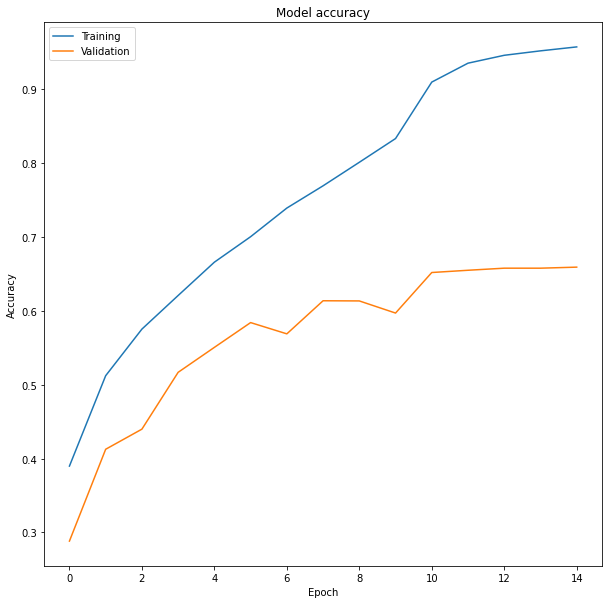

In [29]:
# visualizing the accuracy learning curves

# creating the figure
acc_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history.history['accuracy'])                                                         
plt.plot(history.history['val_accuracy'])  

# setting plot title
plt.title('Model accuracy')

# setting x and y ticks and labels for the plot
plt.ylabel('Accuracy')
#plt.yticks([0.0,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0])
plt.xlabel('Epoch')
#plt.xticks(range(0,num_epochs+1))

# setting the legend for the plot
plt.legend(['Training', 'Validation'], loc='upper left')

# showing the figure
plt.show(acc_lc)

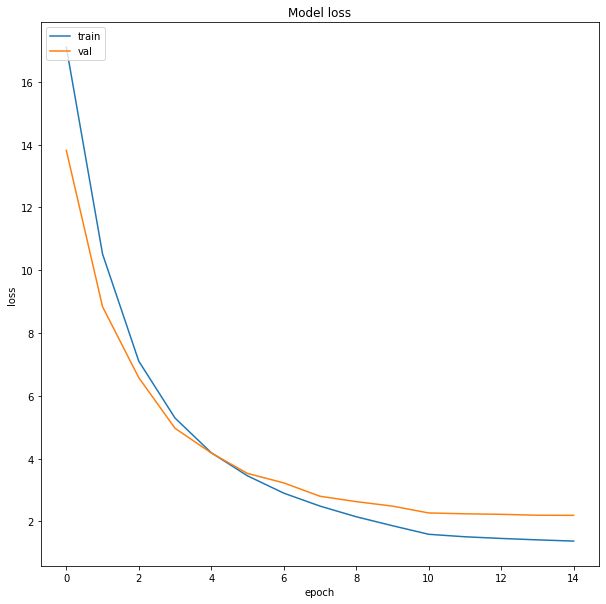

In [30]:
# visualizing the loss learning curves

# creating the figure
loss_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history.history['loss'])                                                         
plt.plot(history.history['val_loss'])  

# setting plot title
plt.title('Model loss')

# setting x and y ticks and labels for the plot
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.xticks(range(0,num_epochs+1))

# setting the legend for the plot
plt.legend(['train', 'val'], loc='upper left')

# showing the figure
plt.show(loss_lc)

## Testing 
In this section the test phase is carried out for the net that has just been trained.


In [31]:
test_history = model.evaluate(X_test,y_test,batch_size = 8)
print("Test Loss : %f , Test Accuracy : %f" %(test_history[0],test_history[1]))

533/533 [==============================] - 3s 6ms/step - loss: 2.1869 - accuracy: 0.6590
Test Loss : 2.186869 , Test Accuracy : 0.659000


## Saving the model
After training and testing the model we save it for future use.

In [32]:
model.save("/content/drive/MyDrive/Facial-Expression-Recognition/Five_Layers_CNN_Classic.h5")

# Training the Five-Layers-CNN using Stratified K-Fold Strategy
In this section Five-Layers-CNN will be trained following the K-Fold Cross Validation strategy. It was decided to implement this strategy to combat the previously encountered overfitting.

## Builiding the Five-Layers-CNN from scratch
Here the architecture of Five-Layers-CNN is created from scratch.



In [42]:
model = Sequential()
model._name = "Five-Layers-CNN"


# First Layer : Input

# Second Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),input_shape = (48, 48, 1),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 64,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.1))
#-------------------------------------------------------------------------------------------------------------------------------#

# Third Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Conv2D(filters = 128,kernel_size = (3, 3),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.01),bias_regularizer = L2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(MaxPooling2D(pool_size = (2, 2),strides = (2,2)))
model.add(Dropout(0.25))
#-------------------------------------------------------------------------------------------------------------------------------#

# Fourth Layer
#-------------------------------------------------------------------------------------------------------------------------------#
model.add(Flatten(name='flatten'))     
model.add(Dense(512))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.1))
model.add(Dense(7,activation='softmax'))


# After creating the structure of the network, we visualize it in a compact way.
model.summary()

Model: "Five-Layers-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_30 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_30 (ReLU)             (None, 48, 48, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_31 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_31 (ReLU)             (None, 48, 48, 64)    

## Creating the Train-Test split
In this section the split is created with the use of the sklearn library.\
This is useful for applying the Stratified K-Fold Cross Validation strategy.

In [43]:
# Creating the X numpyarray
X = df_icml["pixels"]
X = np.stack(X, axis=0)
print("X has shape: ")
print(X.shape)

# Creating the y numpyarray
y = df_icml["emotion"].to_numpy()
y = to_categorical(y)
print("y has shape: ")
print(y.shape)

# Data Augmentation phase 

# Declaration of the ImageDataGenerator with the transformations to apply to generate new images
data_gen = ImageDataGenerator(rotation_range = 15,width_shift_range = 0.15,height_shift_range = 0.15,shear_range = 0.15,zoom_range = 0.15,horizontal_flip = True)

# Disgust Class 

# Creating the X numpyarray with samples from disgust class
X_disg = df_icml.loc[df_icml['emotion'].isin([1])]["pixels"]
X_disg = np.stack(X_disg, axis=0)
print("X_disg has shape: ")
print(X_disg.shape)

# Creating the y numpyarray with samples from disgust class
y_disg = np.zeros((547,7))
for i in range (0,y_disg.shape[0]):
  y_disg[i][1] = 1 
print("y_disg has shape: ")
print(y_disg.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_disg)
  it = data_gen.flow(X_disg,y_disg,batch_size = 547,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1


# Surprise Class 

# Creating the X numpyarray with samples from surprise class
X_surp = df_icml.loc[df_icml['emotion'].isin([5])]["pixels"]
X_surp = np.stack(X_surp, axis=0)
print("X_surp has shape: ")
print(X_surp.shape)

# Creating the y numpyarray with samples from surprise class
y_surp = np.zeros((4002,7))
for i in range (0,y_surp.shape[0]):
  y_surp[i][5] = 1 
print("y_surp has shape: ")
print(y_surp.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_surp)
  it = data_gen.flow(X_surp,y_surp,batch_size = 200,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1


print("\n")
# Creating the train,val,test split using sklearn library 
# ( the stratify option retains the same proportion of classes in the train and test
#  sets that are found in the entire original dataset,it helps in the building of balanced train-test splits)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True,stratify=y)

print("Numpy array shapes:")
print("X_train has shape: ")
print(X_train.shape)
print("y_train has shape: ")
print(y_train.shape)
print("X_test has shape: ")
print(X_test.shape)
print("y_test has shape: ")
print(y_test.shape)

print("\n")
# Transforming sets from numpy array to tensors
X_train = convert_to_tensor(X_train)
X_test = convert_to_tensor(X_test)
print("Tensor shapes:")
print("X_train has shape: ")
print(X_train.shape)
print("y_train has shape: ")
print(y_train.shape)
print("X_test has shape: ")
print(X_test.shape)
print("y_test has shape: ")
print(y_test.shape)

X has shape: 
(35887, 48, 48, 1)
y has shape: 
(35887, 7)
X_disg has shape: 
(547, 48, 48, 1)
y_disg has shape: 
(547, 7)


X_surp has shape: 
(4002, 48, 48, 1)
y_surp has shape: 
(4002, 7)




Numpy array shapes:
X_train has shape: 
(29827, 48, 48, 1)
y_train has shape: 
(29827, 7)
X_test has shape: 
(12783, 48, 48, 1)
y_test has shape: 
(12783, 7)


Tensor shapes:
X_train has shape: 
(29827, 48, 48, 1)
y_train has shape: 
(29827, 7)
X_test has shape: 
(12783, 48, 48, 1)
y_test has shape: 
(12783, 7)


## Assignment of class weights
In this section, class weights are calculated and assigned. These weights are useful in the training phase to manage the imbalance between classes that emerged in the Exploratory Data Analysis.
The following formula will be used to calculate the class weights:\
          **wj = n_samples / (n_classes * n_samplesj)**\
where:


*   wj is the weight for each class (j is the index of the class)
*   n_samples is the total number of samples or rows in the dataset
*   n_classes is the total number of unique classes in the dataset
*   n_samplesj is the total number of rows of the respective class (j is the index of the class)





In [44]:
# computing the total number of samples in the train set
n_samples = y_train.shape[0]

# declaration of the weights dictionary to pass in the training phase
weights = {0:0.0,1:0.0,2:0.0,3:0.0,4:0.0,5:0.0,6:0.0}

# counting n_samples j for each class
for j in range(n_samples):
  idx = y_train[j].argmax()
  weights[idx]=weights[idx]+1

# computing the weights for each class
for j in range(7):
  weights[j] = n_samples/ (7* weights[j])

# visualizing the weights
display(weights)

{0: 1.2290164407268531,
 1: 1.1128231914337947,
 2: 1.1885634588563458,
 3: 0.6772091544818818,
 4: 1.0016455101081336,
 5: 1.049248953459739,
 6: 0.9820235077206729}

## Training
In this section the model is compiled, in particular are defined:

* the loss function (categorical crossentropy)
* the optimizator (adam optimizer)
* the evaluation metrics (accuracy)

After, the model is trained using the K-Fold Cross Validation strategy.

In [45]:
# defining the loss function,the optimizer and the evaluation metrics
opt = keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)

In [46]:
# Declaration of the Stratified K-Fold object 
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1) 

# Declaration of the array in which the loss and accuracy of the evaluation phase of each fold will be stored
folds_results = []

# Declaration of fold index variable 
fold_idx = 1

# Iteration through various folds
for train_index, val_index in skf.split(X_train, y_train.argmax(1)): 
   
    # Creating the train and val folds
    # We will use the train fold to train the model and the val to evaluate the model performance
    X_train_fold, X_val_fold = X[train_index], X[val_index] 
    y_train_fold, y_val_fold = y[train_index], y[val_index] 

    # Training the model
    print("----------------------------------------------------------------------------------------------------------------")
    print("Training the model with the fold number %d\n" %(fold_idx))
    history = model.fit(X_train_fold, y_train_fold,epochs=5,batch_size=32,class_weight=weights) 
    print("\n")

    # Evaluating the model
    print("Evaluating the model with the fold number %d\n" %(fold_idx))
    folds_results.append(model.evaluate(X_val_fold, y_val_fold))
    print("\n")

    # Updating fold index
    fold_idx = fold_idx+1

----------------------------------------------------------------------------------------------------------------
Training the model with the fold number 1

Epoch 1/5
839/839 [==============================] - 21s 23ms/step - loss: 9.6449 - accuracy: 0.3721
Epoch 2/5
839/839 [==============================] - 19s 23ms/step - loss: 7.2782 - accuracy: 0.4921
Epoch 3/5
839/839 [==============================] - 19s 22ms/step - loss: 5.6480 - accuracy: 0.5563
Epoch 4/5
839/839 [==============================] - 19s 22ms/step - loss: 4.5540 - accuracy: 0.6076
Epoch 5/5
839/839 [==============================] - 19s 22ms/step - loss: 3.7896 - accuracy: 0.6606


Evaluating the model with the fold number 1

94/94 [==============================] - 1s 8ms/step - loss: 3.9072 - accuracy: 0.5327


----------------------------------------------------------------------------------------------------------------
Training the model with the fold number 2

Epoch 1/5
839/839 [============================

In [48]:
# Getting the average model accuracy
avg_accuracy = 0.0
avg_loss = 0.0
for i in folds_results:
  avg_loss = avg_loss + i[0]
  avg_accuracy = avg_accuracy + i[1]

avg_accuracy = avg_accuracy/n_splits
avg_loss = avg_loss / n_splits

print("Average model accuracy : %f\n" %(avg_accuracy))
print("Average model loss : %f\n" %(avg_loss))

Average model accuracy : 0.856953

Average model loss : 1.089200



## Testing
In this section the test phase is carried out for the net that has just been trained.


In [50]:
test_history = model.evaluate(X_test,y_test,batch_size = 8)
print("Test Loss : %f , Test Accuracy : %f" %(test_history[0],test_history[1]))

1598/1598 [==============================] - 7s 4ms/step - loss: 1.5424 - accuracy: 0.7893
Test Loss : 1.542350 , Test Accuracy : 0.789330


## Saving the model
After training and testing the model we save it for future use.

In [51]:
model.save("/content/drive/MyDrive/Facial-Expression-Recognition/Five_Layers_CNN_K-Fold.h5")

# Visualizing performances
In this section, the newly trained net is tested on a batch of a chosen size. More specifically, the batch of random images will be displayed and the real labels will be compared with those predicted by the model.


In [52]:
# Definizione della funzione che crea un batch lungo n di samples dal set passato
def random_images(X,n):
  X_len = X.shape[0]
  ran_indices = random.sample(range(0,X_len,1),n)
  list = []
  for i in range(0,n):
    list.append(X[ran_indices[i]])

  return tf.stack(list),ran_indices

In [56]:
n = int(input("Inserisci qui il numero di sample su cui fare testing.\n"))

Inserisci qui il numero di sample su cui fare testing.
20


1/1 [==============================] - 0s 160ms/step
Groundtruth:



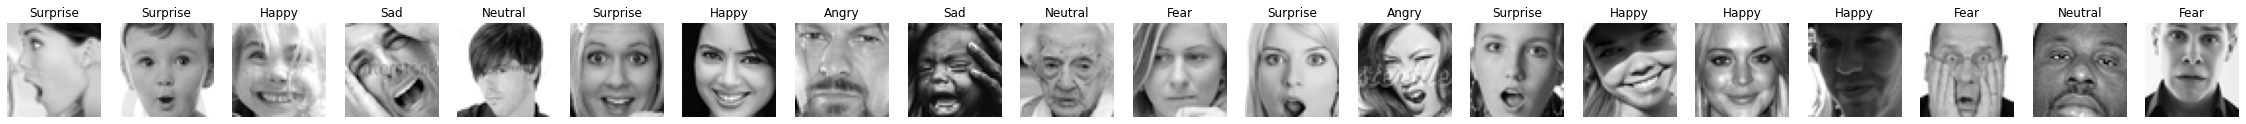



Predictions:



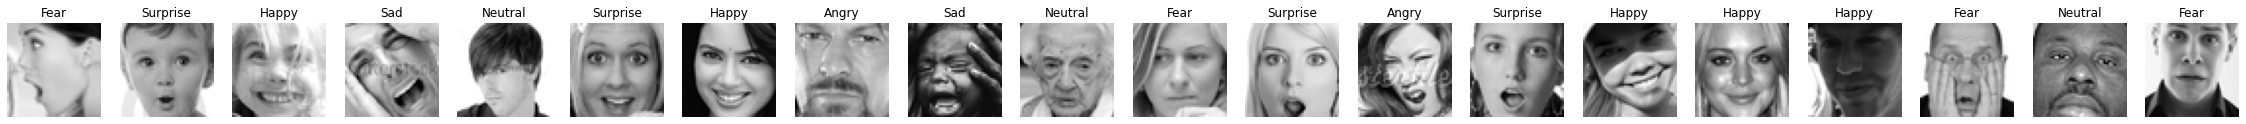

In [57]:
# Checking the output of the newly trained network on a random sample of n images from the test set
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
images,indexes = random_images(X_test,n)
predictions = model.predict(images)

# Viewing the images in the batch with their correct labels
fig1 = plt.figure(figsize=(2*n, 2*n))
print("Groundtruth:\n")
j=1
for i in range(0,n):
  fig1.add_subplot(1,n,j)
  plt.axis("off")
  plt.imshow(images[i].numpy().reshape(48,48),cmap="gray")
  plt.title(emotions[y_test[indexes[i]].argmax()])
  j = j+1
plt.show(fig1)
print("\n")

# Viewing the images in the batch with their predicted labels
fig2 = plt.figure(figsize=(2*n, 2*n))
print("Predictions:\n")
j=1
for i in range(0,n):
  fig2.add_subplot(1,n,j)
  plt.axis("off")
  plt.imshow(images[i].numpy().reshape(48,48),cmap="gray")
  plt.title(emotions[predictions[i].argmax()])
  j = j+1
plt.show(fig2)